In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [19]:
# OLD
# Function to plot descision boundry
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = model(grid).detach().numpy()
    Z = (Z > 0.5).reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, edgecolor='k', cmap=plt.cm.Spectral)
    plt.title('Decision Boundary')
    plt.show()

**XOR Dataset Generation**

In [3]:
# Generate XOR dataset
def generate_XOR_dataset(num_samples=200):
    X = np.random.rand(num_samples, 2)  # Generate random input data
    y = np.zeros(num_samples)           # Initialize labels
    for i in range(num_samples):
        y[i] = 1 if (X[i, 0] > 0.5) != (X[i, 1] > 0.5) else 0
    return X, y

# Split dataset into train, validation, and test sets
X, y = generate_XOR_dataset(200)
train_X, temp_X, train_y, temp_y = train_test_split(X, y, test_size=0.4, random_state=42)
val_X, test_X, val_y, test_y = train_test_split(temp_X, temp_y, test_size=0.5, random_state=42)

# Convert numpy arrays to PyTorch tensors
train_X, val_X, test_X = map(torch.tensor, (train_X, val_X, test_X))
train_y, val_y, test_y = map(torch.tensor, (train_y, val_y, test_y))

train_X, val_X, test_X = train_X.float(), val_X.float(), test_X.float()
train_y, val_y, test_y = train_y.float(), val_y.float(), test_y.float()

**a) MLP Model**

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 4)
        self.out = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.out(x))
        return x

**Training the MLP model**

In [5]:
def train_model(model, train_X, train_y, val_X, val_y, num_epochs=100, l1_penalty=0, l2_penalty=0):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=l2_penalty)  # Weight decay for L2
    best_val_acc = 0

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_X).squeeze()
        loss = criterion(outputs, train_y)

        # Add L1 regularization
        if l1_penalty > 0:
            l1_loss = model.l1_loss(l1_penalty)
            loss += l1_loss

        loss.backward()
        optimizer.step()

        # Validation step
        model.eval()
        val_outputs = model(val_X).squeeze().detach()
        val_preds = (val_outputs > 0.5).float()
        val_acc = accuracy_score(val_y, val_preds)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    print(f'Best Validation Accuracy: {best_val_acc * 100:.2f}%')
    return model

Best Validation Accuracy: 100.00%


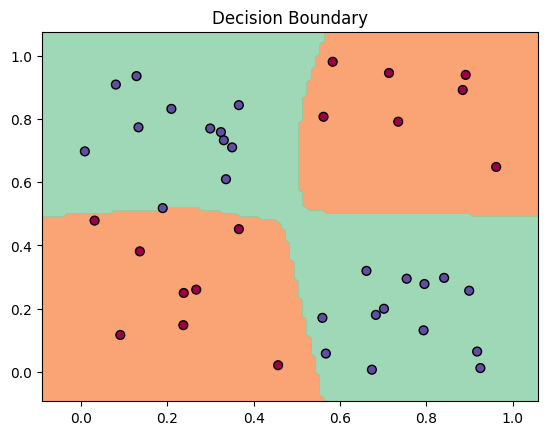

In [21]:
# Train and evaluate MLP model
mlp_model = MLP(input_dim=2)
mlp_model = train_model(mlp_model, train_X, train_y, val_X, val_y, num_epochs=100)

# Plot decision boundary for MLP model
plot_decision_boundary(mlp_model, test_X.numpy(), test_y.numpy())

**Comments:**
The MLP model is able to correctly predict the XOR dataset with non-linearly separable boundary.

**b) MLP Model with L1 regularization**


In [7]:
class MLP_L1(nn.Module):
    def __init__(self, input_dim):
        super(MLP_L1, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 4)
        self.out = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.out(x))
        return x

    def l1_loss(self, l1_penalty):
        l1_loss = 0
        for param in self.parameters():
            l1_loss += torch.sum(torch.abs(param))
        return l1_loss * l1_penalty

**Training the MLP L1 model**

Best Validation Accuracy: 100.00%


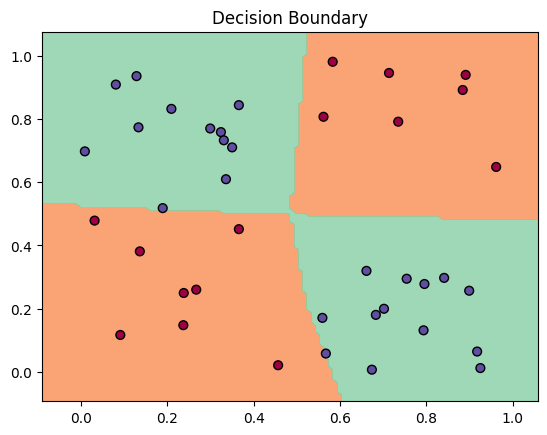

In [8]:
# Train and evaluate MLP model with L1 regularization
mlp_l1_model = MLP_L1(input_dim=2)
mlp_l1_model = train_model(mlp_l1_model, train_X, train_y, val_X, val_y, num_epochs=100, l1_penalty=1e-6)

# Plot decision boundary for MLP with L1 regularization
plot_decision_boundary(mlp_l1_model, test_X.numpy(), test_y.numpy())

**Comments:** The MLP model along with L1 regularization (LASSO regression which penalizes the higher order terms to be zero), is able to detect the XOR dataset correctly. The l1 penalty is taken to be 1e-6, which allows certain higher order terms to be relevant in order to predict the boundaries correctly. If we increase the penalty factor, then the model was showed underfitting behaviour and the results were not obtained to be good.

**c) MLP Model with *L2* regularization**




In [9]:
class MLP_L2(MLP):
    def __init__(self, input_dim):
        super(MLP_L2, self).__init__(input_dim)

Best Validation Accuracy: 100.00%


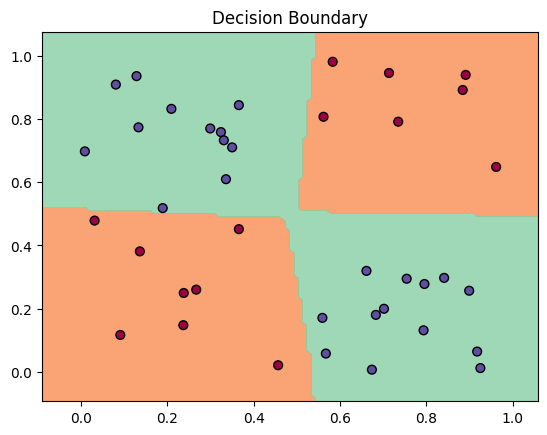

In [10]:
# Train and evaluate MLP model with L2 regularization
mlp_l2_model = MLP_L2(input_dim=2)
mlp_l2_model = train_model(mlp_l2_model, train_X, train_y, val_X, val_y, num_epochs=100, l2_penalty=1e-6)

# Plot decision boundary for MLP with L2 regularization
plot_decision_boundary(mlp_l2_model, test_X.numpy(), test_y.numpy())

**Comments:** The MLP model along with L2 regularization (Ridge regression which penalizes the higher order terms towards zero but not equal to zero), is able to detect the XOR dataset correctly. The l2 penalty is taken to be 1e-6, which allows certain higher order terms to be relevant in order to predict the boundaries correctly. If we increase the penalty factor to 1e-5 or decrease it to 1e-7, then the model was showed underfitting and overfitting behaviour respectively and the results were not obtained to be good.

**d) Logistic *italicised text* Regression model**

In [11]:
class LogisticRegressionPoly(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionPoly, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [12]:
# Use PolynomialFeatures to add interaction terms
poly = PolynomialFeatures(degree=12, include_bias=False)
train_X_poly = poly.fit_transform(train_X.numpy())
val_X_poly = poly.transform(val_X.numpy())
test_X_poly = poly.transform(test_X.numpy())

# Convert the expanded features to tensors
train_X_poly = torch.tensor(train_X_poly, dtype=torch.float32)
val_X_poly = torch.tensor(val_X_poly, dtype=torch.float32)
test_X_poly = torch.tensor(test_X_poly, dtype=torch.float32)

# Logistic Regression Model Definition
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Train Logistic Regression model using PyTorch
def train_logistic_regression(model, train_X, train_y, val_X, val_y, num_epochs=100, learning_rate=0.03):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_acc = 0

    for epoch in range(num_epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        outputs = model(train_X).squeeze()
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()

        # Validation step
        model.eval()
        val_outputs = model(val_X).squeeze().detach()
        val_preds = (val_outputs > 0.5).float()
        val_acc = accuracy_score(val_y, val_preds)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

    print(f'Best Validation Accuracy: {best_val_acc * 100:.2f}%')
    return model

# Initialize and train the logistic regression model
input_dim = train_X_poly.shape[1]  # Use the new dimension after polynomial expansion
log_reg_model = LogisticRegressionModel(input_dim)

# Train the model
trained_log_reg_model = train_logistic_regression(log_reg_model, train_X_poly, train_y, val_X_poly, val_y)

# Evaluate on the test data
test_outputs = trained_log_reg_model(test_X_poly).squeeze().detach()
test_preds = (test_outputs > 0.5).float()
test_acc = accuracy_score(test_y, test_preds)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Best Validation Accuracy: 92.50%
Test Accuracy: 97.50%


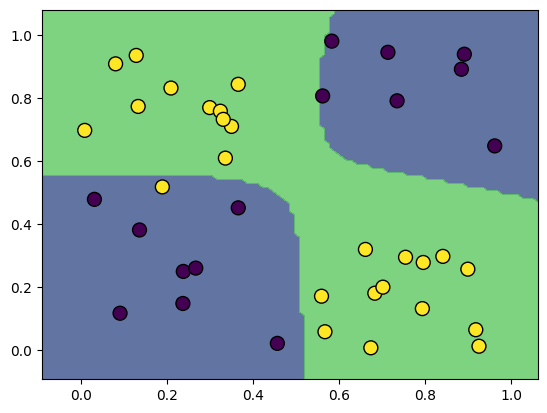

In [13]:
# Decision Boundary Plotting
def plot_decision_boundary(model, X, y, poly):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Transform grid with polynomial features
    grid_poly = poly.transform(grid)
    grid_poly = torch.tensor(grid_poly, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        Z = model(grid_poly).reshape(xx.shape)
    Z = Z > 0.5

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=100)
    plt.show()

# Plot decision boundary
plot_decision_boundary(trained_log_reg_model, test_X.numpy(), test_y.numpy(), poly)

**Comments:** The logistic regression model has a limitation that it cannot predict the decsion boundaries which are not linearly separable. Hence, it cannot predict the XOR dataset accurately unless we add some handcrafted features ourselves. In general if we add x1, x2, x1*x2 then the prediction improves a lot. Hence here we have added polynomial features with high degree terms so that the model is able to learn all the intricacies properly. The polynomial dimension used here is of degree 12 which gives good results.